In [1]:
import gym
import numpy as np
import keras
import random
from __future__ import print_function

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
model = Sequential()
model.add(Conv2D(16, (8, 8), padding='same',
                 input_shape=(105,80,2)))
model.add(Activation('relu'))
model.add(Conv2D(32, (4, 4)))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))


"""
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))"""

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(4)) # number of actions
#model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


In [9]:
frame_old = env.reset()
frame_new, reward, is_done, _ = env.step(env.action_space.sample())
state = np.array([preprocess(frame_old), preprocess(frame_new)]).reshape(105, 80, 2)

In [10]:
model.predict(state.reshape(1,105, 80, 2), batch_size=1)

array([[ 10.16893387,   9.68431473,  14.90043354,  -3.45087957]], dtype=float32)

In [5]:
env = gym.make("BreakoutDeterministic-v4")


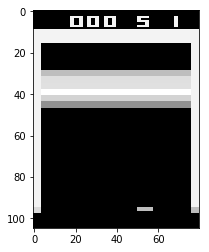

In [11]:

#frame_diff = preprocess(frame_1) - preprocess(frame_2)
#frame_1=frame_2

fig,ax = plt.subplots()
im = ax.imshow(preprocess(frame_old), cmap="gray") 

gamma = 0.9
buffer = 80
batchSize = 40

rewards = []

replay = []
h = 0

def prep_frames(f1, f2):
    return np.array([preprocess(f1), preprocess(f2)])

In [ ]:
for i in range(1):
    
    # doing first two steps here to get enough for initial state
    frame_old = env.reset()

    frame_new, reward, is_done, _ = env.step(env.action_space.sample())

    while not is_done:
        # STATE
        orig_state = np.array([preprocess(frame_old), preprocess(frame_new)]).reshape(105, 80, 2)

        # ACTION
        Qvals = model.predict(orig_state.reshape(1,105,80,2), batch_size=1)
        maxQ_ix = np.argmax(Qvals)
        
        frame_old = frame_new

        action = env.action_space.sample()
        #action = maxQ_ix

        # NEW STATE, REWARD
        frame_new, reward, is_done, _ = env.step(action) # totally exploratory

        # new state 
        new_state = np.array([preprocess(frame_old), preprocess(frame_new)]).reshape(105, 80, 2)

        reward = np.sign(reward)
        
        #Experience replay storage
        if (len(replay) < buffer): #if buffer not filled, add to it
            replay.append((orig_state, action, reward, new_state))
        else: 
            if (h < (buffer-1)):
                h += 1
            else:
                h = 0
                
            replay[h] = (orig_state, action, reward, new_state)
            
            #randomly sample our experience replay memory
            minibatch = random.sample(replay, batchSize)
            
            X_train = []
            y_train = []
            for memory in minibatch:
                #Get max_Q(S',a)
                old_state, action, reward, new_state = memory
                old_qval = model.predict(old_state.reshape(1,105,80,2), batch_size=1)
                
                newQ = model.predict(new_state.reshape(1,105,80,2), batch_size=1)
                maxQ = np.max(newQ)
                y = np.zeros((1,4))
                y[:] = old_qval[:]
                update = (reward + (gamma * maxQ))

                y[0][action] = update
                X_train.append(old_state)
                y_train.append(y)
            
            X_train = np.array(X_train)
            y_train = np.array(y_train).reshape(batchSize, 4)
            
            print("Game #: %s" % (i,))
            model.fit(X_train, y_train, batch_size=batchSize, epochs=1, verbose=1)
            
        env.render()
        
        """
        if i % 50 == 0:
            print("qvals", Qvals)
            print("action", action)
            print("reward: ", reward)
            print("frame diff max", np.max(preprocess(frame_new)-preprocess(frame_old)))
            print("new maxQ", new_maxQ)
            print("update", update)
            print("fitting with the following y:", y, "\n\n")"""


fig,ax = plt.subplots()
im = ax.imshow(preprocess(frame_old), cmap="gray") 
env.close()

#env.render()

Game #: 0
Epoch 1/1
40/40 [==============================] - 156s - loss: -1970.8500 - acc: 0.3000
Game #: 0
Epoch 1/1
40/40 [==============================] - 50s - loss: -1093.0066 - acc: 0.5250
Game #: 0
Epoch 1/1
40/40 [==============================] - 19s - loss: -787.1974 - acc: 0.4500
Game #: 0
Epoch 1/1


In [706]:

X_train.shape

(40, 105, 80, 2)

In [649]:
 ######### No replay
        
        """new_Qvals = model.predict(new_state, batch_size=1)
        new_maxQ = np.max(new_Qvals)
    
        update = reward + (gamma * new_maxQ)
        y = np.zeros((1,4))
        y[:] = Qvals[:]
        y[0][action] = update #target output
        
        model.fit(orig_state, y, batch_size=1, epochs=1, verbose=1)"""
        ########

IndentationError: unexpected indent (<ipython-input-649-db013e4a4793>, line 3)

In [623]:
env.action_space.sample()

1

In [645]:
np.max(rewards)


1.0

In [371]:
rgb_to_gray(frame_2)

(210, 160)

In [157]:
env.action_space

Discrete(4)

In [7]:
def to_greyscale(img): # later on, let's turn these binary
    return np.mean(img, axis=2).astype(np.uint8)

def rgb_to_gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray.astype(np.uint8)

def downsample(img):
    return img[::2, ::2]

def preprocess(img):
    return rgb_to_gray(downsample(img))

In [441]:
predPic1 = preprocess(frame_1)#.reshape(1,105,80,1)
predPic2 = preprocess(frame_2)#.reshape(1,105,80,1)
X = np.array([predPic1, predPic2]).reshape(1,105,80,2) # last number is number of pics
np.max(predPic1)

148

In [8]:
def transform_reward(reward):
    return np.sign(reward)

In [ ]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

In [689]:

def atari_model(n_actions):
    # We assume a theano backend here, so the "channels" are first.
    #ATARI_SHAPE = (4, 105, 80)
    
    # tf backend
    ATARI_SHAPE = (105, 80, 2)

    # With the functional API we need to define the inputs.
    frames_input = keras.layers.Input(ATARI_SHAPE, name='frames')
    #actions_input = keras.layers.Input((n_actions,), name='mask')

    # Assuming that the input frames are still encoded from 0 to 255. Transforming to [0, 1].
    normalized = keras.layers.Lambda(lambda x: x / 255.0)(frames_input)
    
    #still want to normalize these, although greyscaled already
    
    # "The first hidden layer convolves 16 8×8 filters with stride 4 with the input image and applies a rectifier nonlinearity."
    conv_1 = keras.layers.convolutional.Convolution2D(
        16, 8, 8, subsample=(4, 4), activation='relu'
    )(normalized)
    # "The second hidden layer convolves 32 4×4 filters with stride 2, again followed by a rectifier nonlinearity."
    conv_2 = keras.layers.convolutional.Convolution2D(
        32, 4, 4, subsample=(2, 2), activation='relu'
    )(conv_1)
    # Flattening the second convolutional layer.
    conv_flattened = keras.layers.core.Flatten()(conv_2)
    # "The final hidden layer is fully-connected and consists of 256 rectifier units."
    hidden = keras.layers.Dense(256, activation='relu')(conv_flattened)
    # "The output layer is a fully-connected linear layer with a single output for each valid action."
    output = keras.layers.Dense(n_actions)(hidden)
    # Finally, we multiply the output by the mask!
    # filtered_output = keras.layers.merge([output, actions_input], mode='mul')

    #model = keras.models.Model(input=[frames_input, actions_input], output=filtered_output)
    model = keras.models.Model(input=frames_input, output=output)
    optimizer = optimizer=keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)
    model.compile(optimizer, loss='mse')
    
    return model

In [690]:

atari_model(2).predict(X, batch_size=1)

/home/beans/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (8, 8), activation="relu", strides=(4, 4))`
/home/beans/.local/lib/python3.5/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (4, 4), activation="relu", strides=(2, 2))`
/home/beans/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("fr...)`


array([[-0.01656071, -0.01670225]], dtype=float32)